# Zillow Bestimate
## Modeling Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import acquire
import prepare
import explore

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# let's bring in the data
df = prepare.prep_zillow()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23796 entries, 11721753 to 10713993
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bath             23796 non-null  float64
 1   bed              23796 non-null  int64  
 2   sqft_calc        23796 non-null  int64  
 3   fips             23796 non-null  int64  
 4   yearbuilt        23796 non-null  int64  
 5   appraised_value  23796 non-null  int64  
 6   tax_amount       23796 non-null  float64
 7   age              23796 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 1.6 MB


In [3]:
# split our data...
train, \
validate, \
test, \
X_train, \
y_train, \
X_validate, \
y_validate, \
X_test, \
y_test = prepare.zillow_split(df, 'appraised_value')

In [4]:
# What are we looking at here?
X_train.head()

,bath,bed,sqft_calc,fips,yearbuilt,age
parcel_id,,,,,,
12690904,3.0,3,2028,6037,1975,42
12925110,2.0,2,1719,6037,1941,76
17084074,2.0,4,1697,6111,1955,62
14413393,2.5,3,1773,6059,1991,26
11160683,2.0,3,1040,6037,1969,48


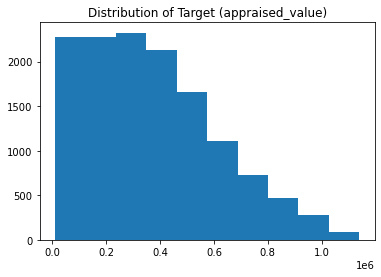

In [5]:
# what is the distribution of our target variable (appraised_value)
plt.hist(y_train)
plt.title('Distribution of Target (appraised_value)')
plt.show()

In [6]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Predict av_pred_mean
av_pred_mean = y_train['appraised_value'].mean()
y_train['av_pred_mean'] = av_pred_mean
y_validate['av_pred_mean'] = av_pred_mean

# RMSE of av_pred_mean
rmse_train = mean_squared_error(y_train['appraised_value'], y_train['av_pred_mean']) ** 0.5
rmse_validate = mean_squared_error(y_validate['appraised_value'], y_validate['av_pred_mean']) ** 0.5

# How did the baseline mean perform
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  239383.52 
Validate/Out-of-Sample:  238334.83


In [7]:
# compute av_pred_median
av_pred_median = y_train['appraised_value'].median()
y_train['av_pred_median'] = av_pred_median
y_validate['av_pred_median'] = av_pred_median

# RMSE of av_pred_mean
rmse_train = mean_squared_error(y_train['appraised_value'], y_train['av_pred_median']) ** 0.5
rmse_validate = mean_squared_error(y_validate['appraised_value'], y_validate['av_pred_median']) ** 0.5

# How did the baseline mean perform
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  241720.83 
Validate/Out-of-Sample:  240874.47


In [8]:
# Clean it up now
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate.round(2),
    'r^2_validate': explained_variance_score(y_validate['appraised_value'], y_validate['av_pred_mean'])}])

In [9]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,240874.47,-2.220446e-16


In [10]:
y_train.head()

,appraised_value,av_pred_mean,av_pred_median
parcel_id,,,
12690904,888000,373063.428818,339530.0
12925110,76995,373063.428818,339530.0
17084074,70691,373063.428818,339530.0
14413393,792686,373063.428818,339530.0
11160683,87748,373063.428818,339530.0


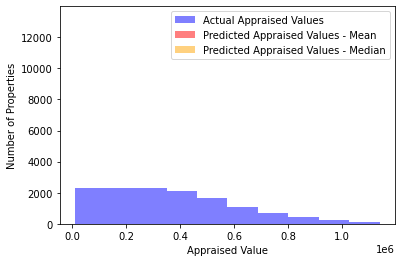

In [11]:
# plot to visualize actual vs predicted. 
plt.hist(y_train['appraised_value'], color='blue', alpha=.5, label="Actual Appraised Values")
plt.hist(y_train['av_pred_mean'], bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Appraised Values - Mean")
plt.hist(y_train['av_pred_median'], bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Appraised Values - Median")
plt.xlabel("Appraised Value")
plt.ylabel("Number of Properties")
plt.legend()
plt.ylim()
plt.show()

#### Linear Regression

In [12]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train['appraised_value'])

# predict train
y_train['av_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train['appraised_value'], y_train['av_pred_lm']) ** (1/2)
# predict validate
y_validate['av_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['appraised_value'], y_validate['av_pred_lm']) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  211411.11802263086 
Validation/Out-of-Sample:  212701.85814930536


In [13]:

metric_df = metric_df.append(
    {
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate['appraised_value'], y_validate['av_pred_lm'])}, ignore_index=True)
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,240874.470000,-2.220446e-16
1,OLS lm 1,212701.858149,2.035097e-01


#### LassoLars

In [14]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train['appraised_value'])

# predict train
y_train['av_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train['appraised_value'], y_train['av_pred_lars']) ** 0.5

# predict validate
y_validate['av_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['appraised_value'], y_validate['av_pred_lars']) ** 0.5

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  211395.43736635265 
Validation/Out-of-Sample:  212690.75875564947


In [15]:
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate['appraised_value'], y_validate['av_pred_lars'])}, ignore_index=True)
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,240874.470000,-2.220446e-16
1,OLS lm 1,212701.858149,2.035097e-01
2,LassoLars alpha 1,212690.758756,2.035923e-01


#### TweedieRegressor (GLM)

In [16]:

# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 

glm.fit(X_train, y_train['appraised_value'])

# predict train
y_train['av_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train['appraised_value'], y_train['av_pred_glm']) ** 0.5


# predict validate
y_validate['av_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['appraised_value'], y_validate['av_pred_glm']) ** 0.5


print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  239383.51569409552 
Validation/Out-of-Sample:  238334.83408501098


In [17]:
metric_df = metric_df.append(
    {
    'model': 'GLM Model power 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate['appraised_value'], y_validate['av_pred_glm'])}, ignore_index=True)
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,240874.470000,-2.220446e-16
1,OLS lm 1,212701.858149,2.035097e-01
2,LassoLars alpha 1,212690.758756,2.035923e-01
3,GLM Model power 1,238334.834085,0.000000e+00


#### Takeaways:
- The mean appears to be a slightly more accurate baseline model, than the median.
- It's average appraised_value prediction is off by `$241k`.
- All three models improve upon the baseline model, and LassoLars in the strongest.
- LassoLars improves upon the baseline by `12 percent`, down to an average residual of `$213k`